# CharRNN + Syllables structure 
A Character level RNN (LSTM) network that takes a dense representation of the number of syllables for the respective line of the poem and accordingly outputs the line for the poem.
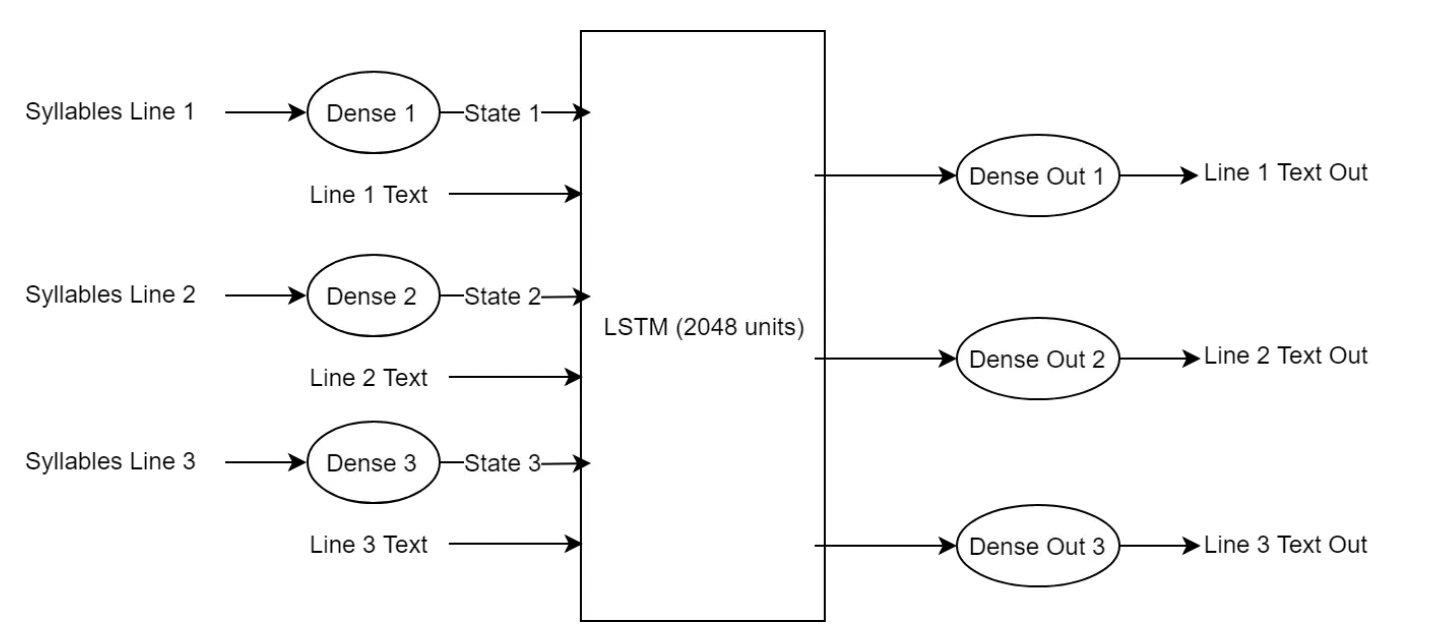


High level diagram of the model. Three dense layers are used to embed the number of syllables for each line into the LSTM’s state. Then text is fed through the LSTM one character at a time and a dense network


# Installs and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Haiku-Generation/haiku_output

/content/drive/MyDrive/Haiku-Generation/haiku_output


In [3]:
import numpy as np
import pandas as pd
import re
import random

import torch
from torch import nn
import torch.nn.functional as F

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda:0'

### Required Functions 

In [5]:
# Pad the lines to the max line length with new lines
def data_manipulation(data,cols = ['clean_sent_1', 'clean_sent_2', 'clean_sent_3'],max_sen_length=61):
    for i in range(3):
        # For input, duplicate the first character
        data['%s_in' % i] = (data[cols[i]].str[0] + data[cols[i]]).str.pad(max_sen_length+2, 'right', '\n')
        
        # TODO - trying to add the next line's first character before the line breaks
        if i == 2: # If it's the last line
            data['%s_out' % i] = data[cols[i]].str.pad(max_sen_length+2, 'right', '\n')
        else: 
            # If it's the first or second line, add the first character of the next line to the end of this line.
            # This helps with training so that the next RNN has a better chance of getting the first character right.
            data['%s_out' % i] = (data[cols[i]] + '\n' + data[cols[i+1]].str[0]).str.pad(max_sen_length+2, 'right', '\n')
    return data

def encoding(data,cols = ['sent_1','sent_2','sent_3']):
    max_sen_length = int(max([data[i].apply(lambda x:len(str(x))).quantile(.99) for i in cols]))
    print('max sentence len: ',max_sen_length)
    data = data[(data[cols[0]].str.len() <= max_sen_length) & (data[cols[1]].str.len() <= max_sen_length) & (data[cols[2]].str.len() <= max_sen_length)].copy()
    print(data.shape)
    data = data_manipulation(data).copy()
    data = data.dropna(axis=0)

    syllables = data[[col for col in data.columns if 'syllable' in col]].values

    input_encoded = []
    output_encoded = []

    for i in range(3):
        # encoding
        input_encoded.append(np.stack(data[str(i)+'_in'].apply(lambda x: np.array([char2int[ch] for ch in str(x)]))))
        output_encoded.append(np.stack(data[str(i)+'_out'].apply(lambda x: np.array([char2int[ch] for ch in str(x)]))))
    
    return np.stack(input_encoded),np.stack(output_encoded),syllables

## Raw text data Type


In [ ]:
with open('data/combined_just_haikus.txt', 'r') as f:
    text = f.read()
print(text[:500])

Memorial Day --/a shadow for each/white cross$
spring rain -/as the doctor speaks/i think of lilacs$
spring moonset --/a rice ball for/breakfast$
sunny afternoon/an old man lingers/near the mailbox$
cinco de mayo/horses roll/in the shallows$
quitting time/the smell of rain/in the lobby$
waves/slowly cresting towards shore/a faint moon$
overnight rain --/the scent of orange blossoms/in a desert town$
misty summer rain/calling pheasant/in Zen temple$
day is done/poppies amidst/the dying grass$
wat


In [ ]:
'''Cleaning'''
# regex remove not A-Za-z0-9
import re
string = "[A-Za-z0-9|/|$|\n|' ']"
text = "".join(re.findall(string,text))

'''Encoding'''
# encode the text and map each character to an integer and vice versa
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

In [ ]:
# data = pd.Series(text.split("$\n")).apply(lambda x: [char2int[ch] for sen in x for ch in sen])

In [ ]:
data = pd.Series(text.split("$\n")).str.split('/',expand=True)
data.drop([3,4,5,6],axis=1,inplace=True)
data.columns = ['sen1','sen2','sen3']
data.head()

,sen1,sen2,sen3
0,Memorial Day,a shadow for each,white cross
1,spring rain,as the doctor speaks,i think of lilacs
2,spring moonset,a rice ball for,breakfast
3,sunny afternoon,an old man lingers,near the mailbox
4,cinco de mayo,horses roll,in the shallows


In [ ]:
'''Pad the Encoding not needed since we padded the sentence'''
# def padding(sen,max_sen_len=50):
#     temp = np.zeros(max_sen_len,dtype=int)
#     if len(sen)>max_sen_len:
#         temp = sen[:max_sen_len]
#     else:
#         temp[:len(sen)] = sen
#     return temp

# data_encoded = []   
# for i in [i for i in data.columns if 'encoded' in i]:
#     data[i] = data[i].apply(lambda x: padding(x))
#     data_encoded.append(np.stack(list(data[i])))

# data_encoded = np.stack(data_encoded,axis=1)
# data_encoded.shape

'Pad the Encoding not needed since we padded the sentence'

In [ ]:
def to_categorical(y, num_classes=len(chars)):
    """one-hot encodes a tensor"""
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
# glove embeddings ?

# one hot endoding
temp = np.apply_along_axis(func1d=to_categorical,arr=data_encoded, axis=2)
print(data_encoded.shape,"===>" ,temp.shape)

(152255, 3, 54) ===> (152255, 3, 54, 67)


# Pre Processed data - with Char and Syllables


In [6]:
data = pd.read_csv('/content/drive/MyDrive/CIS530-Project/Data/preprocessed_cleaned_data_99k.csv')
data.head()

,sent_1,sent_2,sent_3,source,topic,sent_1_syllable,sent_2_syllable,sent_3_syllable,sent_1_phoneme,sent_2_phoneme,sent_3_phoneme
0,"Damn, I really miss.",Us in our early days.,In our best days.,twaiku,best days,5.0,7.0,5.0,daem ay rih|liy mihs,ahs ihn aw|er er|liy deyz,ihn aw|er behst deyz
1,I've never wanted.,To go to Utah more in.,My entire life.,twaiku,never wanted,5.0,7.0,5.0,ayv neh|ver waan|taxd,tax gow tax yuw|tao maor ihn,may axn|tay|er layf
2,ALL people have the.,Capability to change.,"They just choose not, too.",twaiku,capability to,5.0,7.0,5.0,aol piy|paxl hhaev dhax,key|pax|bih|lax|tiy tax cheynjh,dhey jhahst chuwz naat tuw
3,Southern comfort and.,Tea with a bit of honey.,And a dash of ice.,twaiku,and tea,5.0,7.0,5.0,sah|dhern kahm|fert aend,tiy wihdh ax biht ahv hhah|niy,aend ax daesh ahv ays
4,We are both courses.,But is structured as a pimp.,Now Newt inquired.,twaiku,is,5.0,7.0,5.0,wiy aar bowth kaor|saxz,baht ihz strahk|cherd aez ax pihmp,naw nuwt axn|kway|erd


In [7]:
string = "[A-Za-z0-9|/|$|\n|' ']"
for i in data.columns[:3]:
    data[i]=data[i].str.strip()
    data['clean_'+str(i)]=data[i].apply(lambda x: "".join(re.findall(string,str(x))))

In [8]:
text = " ".join(list(pd.Series(list(data[['clean_sent_1', 'clean_sent_2', 'clean_sent_3']].astype(str).values)).apply(lambda x: ' '.join(x)+"$\n")))
print(text[:500])

Damn I really miss Us in our early days In our best days$
 I've never wanted To go to Utah more in My entire life$
 ALL people have the Capability to change They just choose not too$
 Southern comfort and Tea with a bit of honey And a dash of ice$
 We are both courses But is structured as a pimp Now Newt inquired$
 Is there anyone That thinks Russell Wilson won't Go into the HOF$
 Just a reminder That tonight's hip hop fitness Class has been canceled$
 Yes they are really That stupid at the leve


In [9]:
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
print("Number of chars ", len(chars))

Number of chars  67


In [10]:
input_encoded,output_encoded,syllables = encoding(data,cols=['clean_sent_1', 'clean_sent_2', 'clean_sent_3'])
print(input_encoded.shape,output_encoded.shape,syllables.shape)

max sentence len:  61
(98034, 14)
(3, 98022, 63) (3, 98022, 63) (98022, 3)


In [11]:
def to_categorical(y, num_classes=len(chars)):
    """one-hot encodes a tensor"""
    return np.eye(num_classes, dtype='uint8')[y]

In [12]:
# one hot endoding
np.apply_along_axis(func1d=to_categorical,arr=input_encoded, axis=2).shape

(3, 98022, 63, 67)

# Network 

In [110]:
class CharSyllableRNN(nn.Module):
    def __init__(self, chars, n_hidden=1024, n_layers=2,
                               drop_prob=0, lr=0.001):
        super().__init__()

        self.n_layers = n_layers
        self.n_hidden = n_hidden
        #lstm layer - here number of characters is the embedding size as the input is one hot encoded
        self.lstm = nn.LSTM(len(chars),n_hidden,n_layers,batch_first=True,dropout=drop_prob)
        # Syllable dense layer
        self.feature = nn.Sequential(nn.Linear(1,n_hidden),nn.ReLU())   
        #dropout layer
        self.dropout=nn.Dropout(drop_prob)
        #output layer
        self.fc=nn.Sequential(nn.Linear(n_hidden,len(chars)))
    
    def forward(self, x, feat, first_line, hidden=None):
        ''' 
        Forward pass through the network. 
        These inputs are x, feature(syllable) and whether it's the first line of poem
        '''
        
        # add feature info to hiiden state and cell state
        op = self.feature(feat.reshape(-1,1).float())
        
        if first_line:
            hidden = (op.unsqueeze(0),op.unsqueeze(0))
        else:
            hidden = tuple((torch.add(hidden[0],op.unsqueeze(0)),torch.add(hidden[1],op.unsqueeze(0))))
        
        out, hidden = self.lstm(x,hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out,hidden
    

In [111]:
# model = CharSyllableRNN(chars)

# Train 

In [ ]:
def train(model, input_encoded,output_encoded,syllables,epochs=10, batch_size=10,max_sen_len=63, lr=0.001, clip=5, print_every=10,val_size = 10000):
    ''' Training a network 
    
        Arguments
        ---------
        model: CharSyllableRNN network
        train_data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        lr: learning rate
        clip: gradient clipping
        print_every: Number of steps for printing training and validation loss
    
    '''
    model.train()
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.7, patience=2)

    criterion = nn.CrossEntropyLoss()

    train_data = (input_encoded[:,:85000,:],output_encoded[:,:85000,:],syllables[:85000,:])
    val_data = (input_encoded[:,85000:,],output_encoded[:,85000:],syllables[85000:,:])

    # train_data = (input_encoded[:,:10,:],output_encoded[:,:10,:],syllables[:10,:])
    # val_data = (input_encoded[:,10:,],output_encoded[:,10:],syllables[10:,:])

    # torch.autograd.set_detect_anomaly(True)
    teacher_forcing_ratio = 0.25

    counter = 0
    for e in range(epochs):
        for i in range(int(train_data[0].shape[1]/batch_size)):
          # print(i)

          input = torch.from_numpy(np.apply_along_axis(func1d=to_categorical,arr=train_data[0][:,i:i+batch_size,:], axis=2)).to(device)
          target = torch.from_numpy(train_data[1][:,i:i+batch_size,:]).to(device)
          target = target.permute(1,0,2).flatten()
          # target = target.permute(1,0,2).contiguous().view(batch_size*3*max_sen_len,-1)
          # target = torch.from_numpy(np.apply_along_axis(func1d=to_categorical,arr=train_data[1][:,i:i+batch_size,:], axis=2)).to(device)
          syllable = torch.from_numpy(train_data[2][i:i+batch_size,:]).to(device)
          
          # zero accumulated gradients
          model.zero_grad()
          loss = 0
          hidden = None

          outputs = []

          for j in range(3):
              # print(j)
              first_line = True if j==0 else False
              # get the output from the model
              output,hidden = model(input[j,:,:].float(), syllable[:,j], first_line, hidden)
              # print(input[j,:,:].shape,output.shape)
              
              outputs.append(output.view(batch_size*max_sen_len,-1))
              # loss += criterion(output.permute(0,2,1), target[j,:])

              if j<2:
                teacher_force = random.random() < teacher_forcing_ratio
                if teacher_force:
                  # print(teacher_force)
                  input[j+1,:,:] = output

          # calculate the loss
          # print(torch.vstack(outputs).shape,target.shape)
          loss += criterion(torch.vstack(outputs), target)

          # perform backprop
          loss.backward(retain_graph=True)
              
          nn.utils.clip_grad_norm_(model.parameters(), clip)
          optim.step()
          
          # val loss printing
          if counter % print_every == 0:
              val_losses = []
              model.eval()
              for i in range(int(val_data[0].shape[1]/batch_size)):
                  input = torch.from_numpy(np.apply_along_axis(func1d=to_categorical,arr=val_data[0][:,i:i+batch_size,:], axis=2)).to(device)
                  target = torch.from_numpy(val_data[1][:,i:i+batch_size,:]).to(device)
                  target = target.permute(1,0,2).flatten()
                  syllable = torch.from_numpy(val_data[2][i:i+batch_size,:]).to(device)

                  val_loss = 0
                  outputs = []

                  hidden = None
                  for j in range(3):
                    first_line = True if j==0 else False
                    # get op
                    output,hidden = model(input[j,:,:].float(), syllable[:,j], first_line, hidden)

                    outputs.append(output.view(batch_size*max_sen_len,-1))
                    
                    # calculate the loss and perform backprop
                    # val_loss += criterion(output.permute(0,2,1), target[j,:])
                  val_loss += criterion(torch.vstack(outputs), target)
                  val_losses.append(val_loss.item())
              # val_loss = torch.mean(torch.vstack(val_losses))
              
              model.train() # reset to train mode after iterationg through validation data
              
              print("Epoch: {}/{}...".format(e+1, epochs),
                    "Step: {}...".format(counter),
                    "Loss: {:.4f}...".format(loss.item()),
                    "Val Loss: {:.4f}".format(np.mean(val_losses)))
          
          counter+=1
        
        # take schedular step 
        scheduler.step(np.mean(val_losses))

        if (e+1) % 5 == 0:
          # change the name, for saving multiple files
          model_name = 'haiku_lstm_epoch_'+str(e+10)+'.net'
          checkpoint = {'state_dict': model.state_dict(),
                        'tokens': chars,
                        'char2int':char2int,
                        'int2char':int2char}
          with open(model_name, 'wb') as f:
              torch.save(checkpoint, f)

In [ ]:
# define and print the net
model = CharSyllableRNN(chars)
print(model)
batch_size = 256
n_epochs =  10
# train the model
train(model, input_encoded,output_encoded,syllables, epochs=n_epochs, batch_size=batch_size, lr=0.0001, print_every=100)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


CharSyllableRNN(
  (lstm): LSTM(67, 1024, batch_first=True, dropout=0.4)
  (feature): Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU()
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=67, bias=True)
  )
)
Epoch: 1/10... Step: 0... Loss: 4.2165... Val Loss: 4.2014
Epoch: 1/10... Step: 100... Loss: 1.2308... Val Loss: 1.2257
Epoch: 1/10... Step: 200... Loss: 1.2145... Val Loss: 1.2111
Epoch: 1/10... Step: 300... Loss: 1.2107... Val Loss: 1.2072
Epoch: 2/10... Step: 400... Loss: 1.2054... Val Loss: 1.2044
Epoch: 2/10... Step: 500... Loss: 1.2118... Val Loss: 1.2038
Epoch: 2/10... Step: 600... Loss: 1.2076... Val Loss: 1.2044
Epoch: 3/10... Step: 700... Loss: 1.1929... Val Loss: 1.2022
Epoch: 3/10... Step: 800... Loss: 1.2040... Val Loss: 1.2034
Epoch: 3/10... Step: 900... Loss: 1.1966... Val Loss: 1.2036
Epoch: 4/10... Step: 1000... Loss: 1.1956... Val Loss: 1.2025
Epoch: 4/10... Step:

In [ ]:
n_epochs =  20
# train the model
train(model, input_encoded,output_encoded,syllables, epochs=n_epochs, batch_size=batch_size, lr=0.0001, print_every=100)


Epoch: 1/20... Step: 0... Loss: 1.1867... Val Loss: 1.2710
Epoch: 1/20... Step: 100... Loss: 1.1965... Val Loss: 1.2020
Epoch: 1/20... Step: 200... Loss: 1.1933... Val Loss: 1.2028
Epoch: 1/20... Step: 300... Loss: 1.1964... Val Loss: 1.2033
Epoch: 2/20... Step: 400... Loss: 1.1955... Val Loss: 1.2016
Epoch: 2/20... Step: 500... Loss: 1.1931... Val Loss: 1.2031
Epoch: 2/20... Step: 600... Loss: 1.1936... Val Loss: 1.2040
Epoch: 3/20... Step: 700... Loss: 1.1880... Val Loss: 1.2022
Epoch: 3/20... Step: 800... Loss: 1.1945... Val Loss: 1.2019
Epoch: 3/20... Step: 900... Loss: 1.1951... Val Loss: 1.2034
Epoch: 4/20... Step: 1000... Loss: 1.1886... Val Loss: 1.2032
Epoch: 4/20... Step: 1100... Loss: 1.1931... Val Loss: 1.2016
Epoch: 4/20... Step: 1200... Loss: 1.1922... Val Loss: 1.2030
Epoch: 4/20... Step: 1300... Loss: 1.1925... Val Loss: 1.2043
Epoch: 5/20... Step: 1400... Loss: 1.1927... Val Loss: 1.2018
Epoch: 5/20... Step: 1500... Loss: 1.1928... Val Loss: 1.2027
Epoch: 5/20... Step:

# Prediction 

In [18]:
model_name = '/content/drive/MyDrive/Haiku-Generation/haiku_output/haiku_lstm_epoch_29.net'
model_deets = torch.load(model_name)

In [19]:
model_deets.keys()

dict_keys(['state_dict', 'tokens', 'char2int', 'int2char'])

In [21]:
chars = model_deets['tokens']
char2int = model_deets['char2int']
int2char = model_deets['int2char']

model = CharSyllableRNN(chars)
model.load_state_dict(model_deets['state_dict'])
model.to(device)

In [61]:
model.eval()

CharSyllableRNN(
  (lstm): LSTM(67, 1024, batch_first=True, dropout=0.4)
  (feature): Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU()
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=67, bias=True)
  )
)

In [84]:
def get_pred(preds, temperature=1.0):
    '''helper function to sample an index from a probability array'''
    preds = nn.Softmax(dim=1)(preds).squeeze(0).squeeze(0)
    preds = preds.cpu().detach().numpy().astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return int2char[np.argmax(probas)]

In [ ]:
def generator(model,text = 'a',syllable = [5.,7.,5.],max_sen_len = 40,temperature=0.1):
  inp = torch.from_numpy(np.apply_along_axis(func1d=to_categorical,arr=np.array([char2int[ch] for ch in str(text)]), axis=0)).unsqueeze(1).to(device)
  for c in range(len(text)): 
    output,hidden = model(inp[c].unsqueeze(0).float(), torch.tensor([syllable[0]],device=device), True, None)

  pred = list(text)
  pred.append(get_pred(preds=output,temperature=0.1))

  for i in range(3):
    for j in range(max_sen_len):
      if i == 0:
        hidden = None
      first_line = True if i==0 else False
      
      inp = torch.from_numpy(np.apply_along_axis(func1d=to_categorical,arr=np.array([char2int[ch] for ch in str(pred[-1])]), axis=0)).unsqueeze(0).to(device)
      output,hidden = model(inp.float(), torch.tensor([syllable[i]],device=device), first_line, hidden)
      
      pred.append(get_pred(preds=output,temperature=0.1))
      if pred[-1] == '\n':
        continue
    pred.append('/')
  
  return "".join(pred)


In [108]:
print(generator(model,text = 'nature',syllable = [5.,7.,5.],max_sen_len = 40,temperature=0.1))